In [1]:
%cd ..
%load_ext autoreload
%autoreload 2
# %load_ext nb_black
# notebook setup

from pathlib import Path
import sys

sys.path.insert(0, Path().absolute().parent.as_posix())

/Users/ruizhechao/Documents/NNforHJB


/Users/ruizhechao/Documents/NNforHJB/.venv/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [ ]:
# load the data
import numpy as np

path = 'rawdata/raw_data/VDP_beta_0.1_grid_30x30.npy'
data = np.load(path)
data.dtype

dtype([('x', '<f8', (2,)), ('dv', '<f8', (2,)), ('v', '<f8')])

In [ ]:
# prepare the data
# data is a structured numpy array with fields: 'x', 'dv', 'v'
# convert to the dict format expected by model._prepare_data

data_dict = {
    "x": np.asarray(data["x"], dtype=np.float64),    # shape (N, 2)
    "v": np.asarray(data["v"], dtype=np.float64),    # shape (N,)
    "dv": np.asarray(data["dv"], dtype=np.float64),  # shape (N, 2)
}

### Test the PDPA algorithm

In [4]:
import torch
from scr.PDPA import PDPA

pdpa_1 = PDPA(
    data = data_dict,
    alpha = 1e-3, 
    gamma = 5.0,
    power = 2.1,
    activation = torch.relu,
    loss_weights = [1.0, 0.0],
    verbose=True
)

best_iteration_1 = pdpa_1.retrain(
    num_iterations = 20, 
    num_insertion= 5, 
    threshold = 1e-10,
    )

2026-01-21 17:28:03.083 | INFO     | scr.model:__init__:71 - Model initialized
2026-01-21 17:28:03.084 | INFO     | scr.model:__init__:71 - Model initialized
2026-01-21 17:28:03.084 | INFO     | scr.model:_prepare_data:101 - Training set: 810 samples, Validation set: 90 samples
2026-01-21 17:28:03.085 | INFO     | scr.PDPA:retrain:293 - Iteration 1 - Starting...
2026-01-21 17:28:03.085 | INFO     | scr.model:_create_network:140 - Creating network with 5 neurons
2026-01-21 17:28:03.671 | INFO     | scr.model:train:252 - Starting network training session
2026-01-21 17:28:03.687 | INFO     | scr.model:train:317 - Epoch 0: Train Loss = 18.009299, Val Loss = 6.733139
2026-01-21 17:28:03.735 | INFO     | scr.model:train:317 - Epoch 100: Train Loss = 0.751838, Val Loss = 3.334490
2026-01-21 17:28:03.782 | INFO     | scr.model:train:317 - Epoch 200: Train Loss = 0.591515, Val Loss = 3.022967
2026-01-21 17:28:03.828 | INFO     | scr.model:train:317 - Epoch 300: Train Loss = 0.517069, Val Loss =

In [5]:
best_iteration_1

19

## Test effect of different gamma with increased neurons added

In [ ]:
gammas = [10.0, 5.0, 1.0, 1e-1, 1e-2]
alpha = 1e-3
power = 2.1
loss_weight_h1 = [1.0, 1.0]
loss_weight_l2 = [1.0, 0.0]

num_iterations = 20
num_insertions = 5
pruning_threshold = 1e-10

In [ ]:


pdpa_list_l2 = []
best_iteration_l2 = []
for gamma in gammas:
    pdpa = PDPA(
        data=data_dict,
        alpha=alpha,
        gamma=gamma,
        power=power,
        activation=torch.relu,
        loss_weights=loss_weight_l2,
        verbose=False,
    )

    best_iteration = pdpa.retrain(
    num_iterations = num_iterations, 
    num_insertion= num_insertions, 
    threshold = pruning_threshold,
    verbose=False
    )

    pdpa_list_l2.append(pdpa)
    best_iteration_l2.append(best_iteration)


In [ ]:
pdpa_list_h1 = []
best_iteration_h1 = []

for gamma in gammas:
    pdpa = PDPA(
        data=data_dict,
        alpha=alpha,
        gamma=gamma,
        power=power,
        activation=torch.relu,
        loss_weights=loss_weight_h1,
        verbose=False,
    )

    best_iteration = pdpa.retrain(
    num_iterations = num_iterations, 
    num_insertion= num_insertions, 
    threshold = pruning_threshold,
    verbose=False
    )

    pdpa_list_h1.append(pdpa)
    best_iteration_h1.append(best_iteration)

In [ ]:
import pickle

model_l2 = {
    "gammas": gammas,
    "pdpa_list_l2": pdpa_list_l2,
    "alpha": alpha,
    
}

model_h1 = {
    "gammas": gammas,
    "pdpa_list_h1": pdpa_list_h1,
}


with open("models/pdpa_vdp_model_l2_1.pkl", "wb") as f:
    pickle.dump(model_l2, f)

with open("models/pdpa_vdp_model_h1_1.pkl", "wb") as f:
    pickle.dump(model_h1, f)

In [9]:
best_iteration_h1

[18, 10, 13, 7, 7]

In each iteration we tried to add 5 neurons. The following plots indicates the relation of loss & number of neurons. 

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'PDPA validation loss history by γ'}, xlabel='Iteration', ylabel='Validation loss'>)

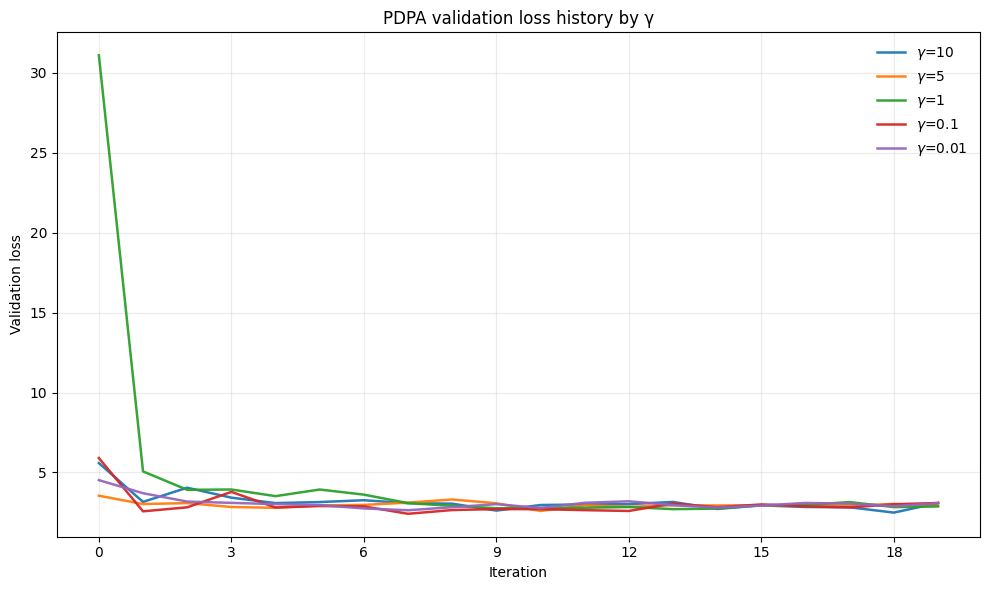

In [10]:
from scr.metric import plot_pdpa_val_loss_histories_by_gamma

plot_pdpa_val_loss_histories_by_gamma(model_h1)

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'PDPA validation loss history by γ'}, xlabel='Iteration', ylabel='Validation loss'>)

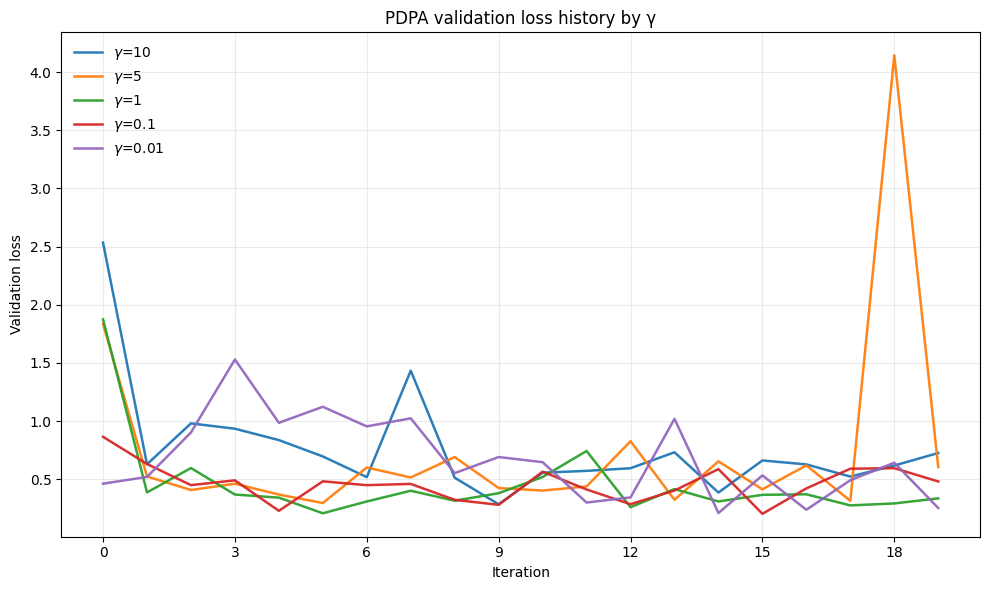

In [11]:
plot_pdpa_val_loss_histories_by_gamma(model_l2, pdpa_key="pdpa_list_l2")

In [ ]:
best_iteration_l2